In [1]:
import pandas as pd
import numpy as np
import math
import json
import os
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

from jupyterthemes import jtplot
jtplot.style(theme='solarizedd')
plt.rcParams['figure.figsize'] = (20.0, 10.0)

import data_utils_mt.utils as utils
import seaborn as sns
from sklearn.pipeline import Pipeline
import datetime as dt
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error as mse

ROOT_DIR = '../..'
DATA_DIR = os.path.join(ROOT_DIR, 'data')
DATA_RAW = os.path.join(DATA_DIR, 'raw')
DATA_INTERIM = os.path.join(DATA_DIR, 'interim')
DATA_EXTERNAL = os.path.join(DATA_DIR, 'external')
DATA_PROCESSED = os.path.join(DATA_DIR, 'processed')
SRC = os.path.join(ROOT_DIR, 'src')

STATIC_DATASET_PATH = os.path.join(DATA_INTERIM, 'static_data.pkl')

import sys
sys.path.append(SRC)

import src.data.preprocessing as pp
import src.data.success_dataset as sd
import src.data.missing_data as md
import src.evaluation.offer_success as evos
import src.data.profit_10_days_dataset as p10
import src.visualization.visualize as vis

In [2]:
# Get the data
X_train, X_test, y_train, y_test, encoder, view_cols, profit_cols =\
p10.get_profit_10_days_data(fill_null=True, 
                        target=['viewed', 'profit_10_days'], drop_offer_id=False)

In [3]:
model = p10.ProfitsPredictor(encoder=encoder, view_cols=view_cols, profit_cols=profit_cols)

In [4]:
%time model.fit(X_train, y_train)

CPU times: user 1min 54s, sys: 1.94 s, total: 1min 56s
Wall time: 2min


ProfitsPredictor(encoder=BasicEncoderProfits(custom_features=None),
         profit_cols=['difficulty', 'duration', 'reward_t', 'channel_web', 'channel_mobile', 'channel_email', 'channel_social', 'offer_id', 'offer_type'],
         view_cols=['difficulty_viewcol', 'duration_viewcol', 'reward_t_viewcol', 'channel_web_viewcol', 'channel_mobile_viewcol', 'channel_email_viewcol', 'channel_social_viewcol', 'offer_id_viewcol', 'offer_type_viewcol'])

In [5]:
y_pred = model.predict(X_train) 
y_pred.shape

(25319, 2)

In [6]:
y_train.shape

(25319, 2)

In [24]:
# Read the data
portfolio = pd.read_json(os.path.join(DATA_RAW, 'portfolio.json'), orient='records', lines=True)
profile = pd.read_json(os.path.join(DATA_RAW, 'profile.json'), orient='records', lines=True)
transcript = pd.read_json(os.path.join(DATA_RAW, 'transcript.json'), orient='records', lines=True)

# Basic Preprocessing
print('Basic preprocessing')
%time _, portfolio = pp.basic_preprocessing(portfolio, profile, transcript)

null_offer = pd.Series([0, 0, 'no_offer', 'no_offer', 0, 0, 0, 0, 0],
                               index=portfolio.columns,
                               name=portfolio.shape[0]).sort_index()

Basic preprocessing
CPU times: user 2.72 s, sys: 225 ms, total: 2.94 s
Wall time: 1.99 s


In [25]:
null_offer

channel_email            0
channel_mobile           0
channel_social           0
channel_web              0
difficulty               0
duration                 0
id                no_offer
offer_type        no_offer
reward                   0
Name: 10, dtype: object

In [26]:
X_null = X_train.copy()

X_null.loc[:, sorted(p10.VIEW_COLS)] = np.repeat(null_offer.values.reshape(1, -1), X_null.shape[0],
                                                           axis=0)
X_null.loc[:, sorted(p10.PROFIT_COLS)] = np.repeat(null_offer.values.reshape(1, -1), X_null.shape[0],
                                                             axis=0)

_, X_null_profits = p10.split_view_profit(X_null,
                                               model.view_cols,
                                               model.profit_cols)
X_views, X_profits = p10.split_view_profit(X_train,
                                               model.view_cols,
                                               model.profit_cols)

In [27]:
X_null_profits.head()

,offer_id,age,gender,income,missing_demographics,member_epoch_days,difficulty,duration,offer_type,reward_t,...,difficulty_7.0_success_ratio,reward_10.0_success_ratio,reward_0.0_success_ratio,reward_5.0_success_ratio,reward_3.0_success_ratio,reward_2.0_success_ratio,channel_web_success_ratio,channel_email_success_ratio,channel_social_success_ratio,channel_mobile_success_ratio
0,no_offer,33.0,M,72000.0,0,17277,0,0,no_offer,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,no_offer,NaN,None,NaN,1,17646,0,0,no_offer,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,no_offer,40.0,O,57000.0,0,17540,0,0,no_offer,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,no_offer,40.0,O,57000.0,0,17540,0,0,no_offer,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,no_offer,59.0,F,90000.0,0,16864,0,0,no_offer,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
# Predict the profits with the null offer
null_profits_pred = model.profits_model.predict(X_null_profits)

/Users/antelinvestigacionydesarrollo/anaconda3/envs/sbucks/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



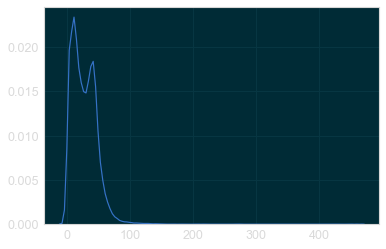

In [31]:
sns.kdeplot(null_profits_pred)

In [32]:
y_pred = model.predict_final_profits(X_train, null_offer)

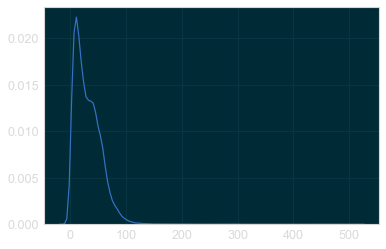

In [33]:
sns.kdeplot(y_pred)